# Introduction to Data Science, CS 5963 / Math 3900
*CS 5963 / MATH 3900, University of Utah, http://datasciencecourse.net/* 

## Lab 10: Classification

In this lab, we will use the [scikit-learn](http://scikit-learn.org/) library to revisit the three classification methods we introduced: K-nearest neighbor, decision trees, and support vector machines. We will use a [dataset on contraceptive methods in Indonesia](https://archive.ics.uci.edu/ml/datasets/Contraceptive+Method+Choice).


## The Data

We will explore a dataset about the use of contraception in Indonesia. The dataset has 1473 records and the following attributes:

1. Woman's age (numerical) 
2. Woman's education (categorical) 1=low, 2, 3, 4=high 
3. Husband's education (categorical) 1=low, 2, 3, 4=high 
4. Number of children ever born (numerical) 
5. Woman's religion (binary) 0=Non-Islam, 1=Islam 
6. Employed? (binary) 0=Yes, 1=No 
7. Husband's occupation (categorical) 1, 2, 3, 4 
8. Standard-of-living index (categorical) 1=low, 2, 3, 4=high 
9. Media exposure (binary) 0=Good, 1=Not good 
10. Contraceptive method used (class attribute) 1=No-use, 2=Long-term, 3=Short-term

### Hypothesis

Write down which features do you think have the most impact on the use of contraception.

## Preliminaries

We'll start with the usual imports:

In [1]:
import numpy as np
import pandas as pd

from sklearn import metrics
from sklearn.cross_validation import train_test_split, cross_val_predict, cross_val_score, KFold

from sklearn import tree

from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier

from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.feature_selection import chi2

from sklearn import svm

import seaborn as sns
sns.set()

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)
plt.style.use('ggplot')

And then load and explore the dataset:

In [2]:
contraception_df = pd.read_csv("cmc.csv")
contraception_df.head()

,Age,Education,Husband-Education,Children,Religion,Employed,Husband-Occupation,Standard-of-living,Media-exposure,Contraceptive-method-used
0,24,2,3,3,1,1,2,3,0,1
1,45,1,3,10,1,1,3,4,0,1
2,43,2,3,7,1,1,3,4,0,1
3,42,3,2,9,1,1,3,3,0,1
4,36,3,3,8,1,1,3,2,0,1


In [3]:
contraception_df.describe()

,Age,Education,Husband-Education,Children,Religion,Employed,Husband-Occupation,Standard-of-living,Media-exposure,Contraceptive-method-used
count,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000
mean,32.538357,2.958588,3.429735,3.261371,0.850645,0.749491,2.137814,3.133741,0.073999,1.919891
std,8.227245,1.014994,0.816349,2.358549,0.356559,0.433453,0.864857,0.976161,0.261858,0.876376
min,16.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000
25%,26.000000,2.000000,3.000000,1.000000,1.000000,0.000000,1.000000,3.000000,0.000000,1.000000
50%,32.000000,3.000000,4.000000,3.000000,1.000000,1.000000,2.000000,3.000000,0.000000,2.000000
75%,39.000000,4.000000,4.000000,4.000000,1.000000,1.000000,3.000000,4.000000,0.000000,3.000000
max,49.000000,4.000000,4.000000,16.000000,1.000000,1.000000,4.000000,4.000000,1.000000,3.000000


Here are a couple of definitions that might come in handy:

In [4]:
cmethod = "Contraceptive-method-used"
labels =["None", "Long-Term", "Short-Term"]
features = ['Age', 'Education', 'Husband-Education', 'Children', 'Religion',
       'Employed', 'Husband-Occupation', 'Standard-of-living',
       'Media-exposure']
religion_children = ['Children', 'Religion',
       'Employed', 'Education']


Let's take a look at the data. How are the contraception methods distributed?

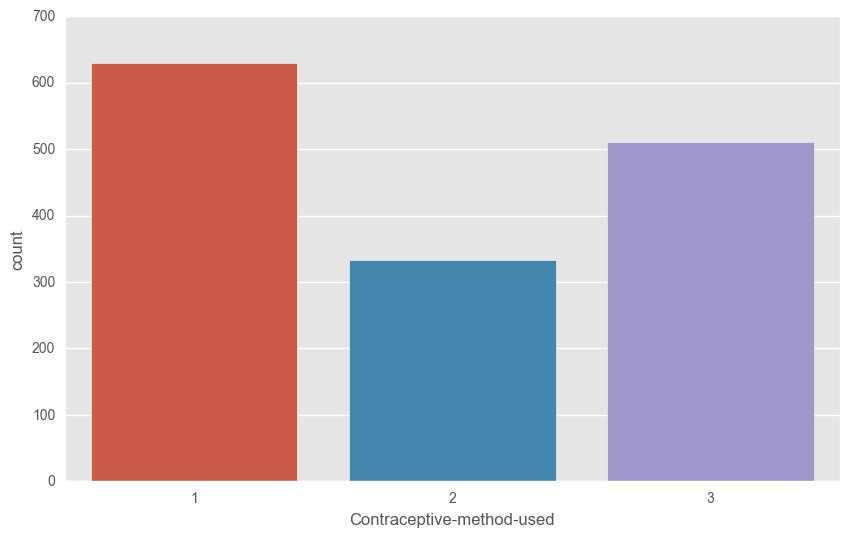

In [5]:
ax = sns.countplot(x=cmethod, data=contraception_df)

Let's look at the age distribution:

/Users/alexsb/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


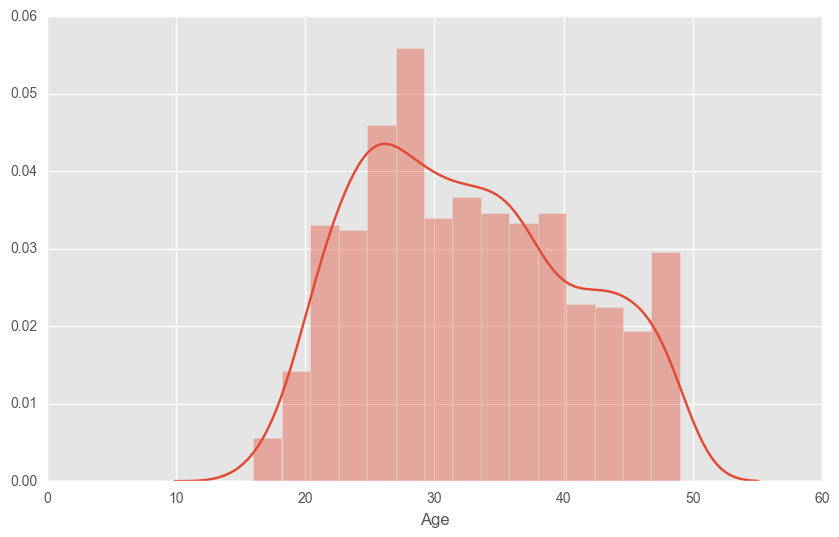

In [6]:
sns.distplot(contraception_df["Age"])

And facet age by contraceptive method:

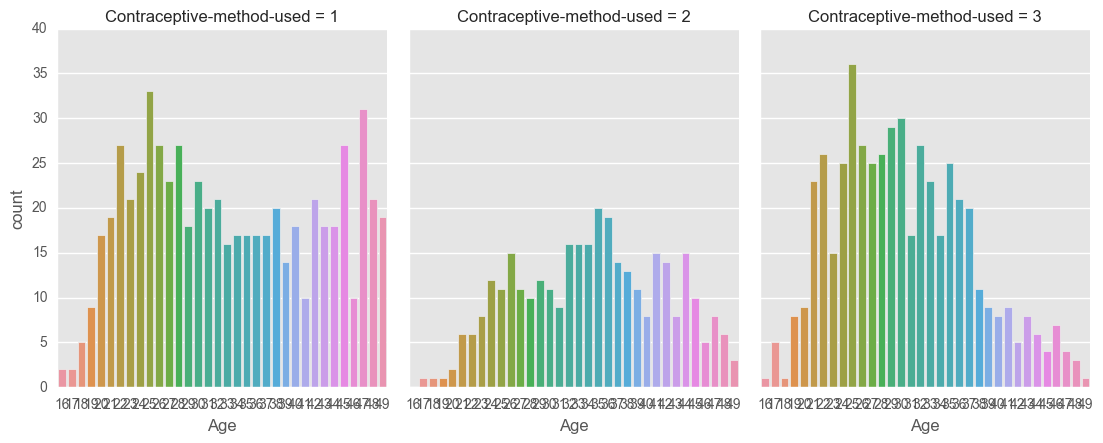

In [7]:
g = sns.factorplot("Age", col=cmethod, col_wrap=4, 
                   data=contraception_df[contraception_df["Age"].notnull()],
                   kind="count", size=4.5, aspect=.8)

We see some patterns, but let's look instead at bar charts split up by contraceptive method.

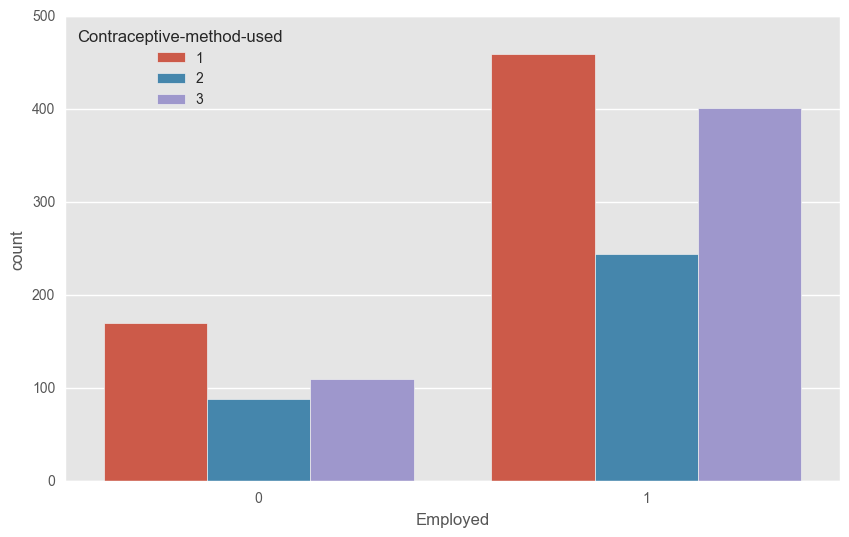

In [8]:
sns.countplot(x="Employed", hue=cmethod, data=contraception_df)

## Splitting The Dataset

Here is some code that splits the data into training and test sets for cross-validation and selects features.

In [9]:
features = contraception_df.columns[:-1]

def splitData(features):
    contraception_labels = contraception_df["Contraceptive-method-used"].as_matrix()
    contraception_predictors =  contraception_df[features].as_matrix()

    # Split into training and test sets
    XTrain, XTest, yTrain, yTest = train_test_split(contraception_predictors, contraception_labels, 
                                                    random_state=1, test_size=0.5)
    return XTrain, XTest, yTrain, yTest

## Finding Features 

Let's take a look at wich features have potentially the most impact on our classification. SciPy comes with [a rich feature selection module](http://scikit-learn.org/stable/modules/feature_selection.html). We'll use univariate methods here, [SelectPercentile](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectPercentile.html#sklearn.feature_selection.SelectPercentile) to have a look at P values, and [SelectKBest](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html#sklearn.feature_selection.SelectKBest) to pick features.

And we'll use the Chi squared test, but there are other methods.

In [10]:
XTrain, XTest, yTrain, yTest = splitData(features)

selector = SelectPercentile(chi2)
X_new = selector.fit_transform(XTrain, yTrain)
print(features)
print("P Values:", selector.pvalues_)

Index(['Age', 'Education', 'Husband-Education', 'Children', 'Religion',
       'Employed', 'Husband-Occupation', 'Standard-of-living',
       'Media-exposure'],
      dtype='object')
P Values: [  2.25968832e-11   5.50021943e-05   1.75383786e-01   9.63642724e-04
   2.26640857e-01   9.91225619e-01   7.38481185e-03   1.15655329e-02
   1.40444374e-03]


In [11]:
selector = SelectKBest(chi2, k=3)
X_new = selector.fit_transform(XTrain, yTrain)
print(features)
selector.get_support()

Index(['Age', 'Education', 'Husband-Education', 'Children', 'Religion',
       'Employed', 'Husband-Occupation', 'Standard-of-living',
       'Media-exposure'],
      dtype='object')


array([ True,  True, False,  True, False, False, False, False, False], dtype=bool)

In [12]:
best_features = ['Age', 'Education', 'Children']

## Visualization Code

And more code for plotting decision trees. This uses pydotplus, if you haven't already, install it:

```
pip install pydotplus
```

You also need to install graphviz. This might be tricky on windows. You can also render the dot files using [this web renderer](http://www.webgraphviz.com/).

In [13]:
from IPython.display import Image, display  
import pydotplus 
from scipy import misc

def renderTree(my_tree):
    # hacky solution of writing to files and reading again
    # necessary due to library bugs
    filename = "temp.dot"
    with open(filename, 'w') as f:
        f = tree.export_graphviz(my_tree, 
                                 out_file=f, 
                                 feature_names=features, 
                                 class_names=labels,  
                                 filled=True, 
                                 rounded=True,
                                 special_characters=True)
  
    dot_data = ""
    with open(filename, 'r') as f:
        dot_data = f.read()

    graph = pydotplus.graph_from_dot_data(dot_data)
    image_name = "temp.png"
    graph.write_png(image_name)  
    display(Image(filename=image_name))

## Task: Explore Other Variables
Visualize the effect of other variables on the predicted classes. 

# Task: Build a Model

Pick one of the following three approaches to model and predict contraception use.

Well do this as a competition in teams of two to three, using pair programming (one person types, the other observe, suggest and do research). 

Report your accuracy scores, we'll put it down on the whiteboard. The group with the best model gets a price!

## Decision Trees

Classify the data using decision trees. Experiment with different depths, minimum samples to split on, and minimum samples to remain after the split, as well as with a combination of different features.

Usse the `splitData()` function to divide your data into training and test sets. 

Refer to the [scikit learn documentation](http://scikit-learn.org/stable/modules/tree.html) and the  [lecture on decision trees](https://github.com/datascience-course/2016-datascience-labs/tree/master/lecture9-decision-trees).

You can use the `renderTree()` function to render the tree, if you have the proper libraries installed.

## K-Nearest Neighbor

Experiment with different numbers of neighbors and different features.

Usse the `splitData()` function to divide your data into training and test sets. 

Refer to the [scikit learn documentation](http://scikit-learn.org/stable/modules/neighbors.html) and the  [lecture on k nearest neighbors](https://github.com/datascience-course/2016-datascience-labs/blob/master/lecture8-classification-kNN/08-classification-kNN.ipynb).

## SVM 

Experiment with different kernels, C values and different features. Use cross validation to find a godd C value. Print accuracy and the confusion matrix.

Refer to the [scikit learn](http://scikit-learn.org/stable/modules/svm.html) documentation and the [lecture on SVM](https://github.com/datascience-course/2016-datascience-labs/blob/master/lecture10-classification-SVM/10-classification-SVM.ipynb).